# Evaluate Classification Models
**Author:** G8  
**Task:** 2.2 - Model Evaluation and Comparison  
**Timeline:** Feb 7, 2025  

**Purpose:**
- Evaluate all 4 trained classification models
- Generate comprehensive metrics
- Create confusion matrices and ROC curves
- Compare model performance

## Setup and Imports

In [16]:
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_recall_fscore_support,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Libraries imported successfully!")
print(f"TensorFlow: {tf.__version__}")

Libraries imported successfully!
TensorFlow: 2.14.0


## Configuration

In [17]:
# Paths
PROJECT_ROOT = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
DATA_PATH = PROJECT_ROOT / "data" / "processed" / "single_objects"
MODELS_PATH = PROJECT_ROOT / "models" / "classification"
RESULTS_PATH = PROJECT_ROOT / "results" / "classification"

# Create output directories
(RESULTS_PATH / 'metrics').mkdir(parents=True, exist_ok=True)
(RESULTS_PATH / 'confusion_matrices').mkdir(parents=True, exist_ok=True)
(RESULTS_PATH / 'roc_curves').mkdir(parents=True, exist_ok=True)
(RESULTS_PATH / 'per_class_accuracy').mkdir(parents=True, exist_ok=True)
(RESULTS_PATH / 'predictions').mkdir(parents=True, exist_ok=True)

# Load class mapping
with open(PROJECT_ROOT / "data" / "class_mapping.json", 'r') as f:
    class_info = json.load(f)

NUM_CLASSES = class_info['num_classes']
class_names = [class_info['idx_to_class'][str(i)] for i in range(NUM_CLASSES)]

print(f"Configuration:")
print(f"  Classes: {NUM_CLASSES}")
print(f"  Results path: {RESULTS_PATH}")

Configuration:
  Classes: 39
  Results path: /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/CNN_Attendance_System/results/classification


## Create Test Data Generator

In [18]:
print("="*80)
print("CREATING TEST DATA GENERATOR")
print("="*80)

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    DATA_PATH / 'test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print(f"\nTest samples: {test_gen.samples}")
print(f"Test batches: {len(test_gen)}")
print(f"Classes: {test_gen.num_classes}")

CREATING TEST DATA GENERATOR
Found 626 images belonging to 39 classes.

Test samples: 626
Test batches: 20
Classes: 39


## Evaluate Each Model

In [19]:
def evaluate_single_model(model_name):
    """
    Evaluate one model and return all metrics
    """
    print("\n" + "="*80)
    print(f"EVALUATING {model_name.upper()}")
    print("="*80)
    
    # Load model
    model_path = MODELS_PATH / f"{model_name}_best.h5"
    print(f"\nLoading: {model_path.name}")
    model = keras.models.load_model(model_path)
    
    # Run predictions on test set
    print("\nRunning inference...")
    start_time = time.time()
    predictions = model.predict(test_gen, verbose=1)
    inference_time = time.time() - start_time
    
    # Get predicted and true classes
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = test_gen.classes
    
    # Calculate metrics
    print("\nCalculating metrics...")
    accuracy = accuracy_score(true_classes, pred_classes)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_classes, pred_classes, average='weighted', zero_division=0
    )
    
    # Model size
    model_size_mb = os.path.getsize(model_path) / (1024 * 1024)
    
    # Inference speed
    avg_time_ms = (inference_time / test_gen.samples) * 1000
    
    metrics = {
        'model': model_name,
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'inference_time_ms': float(avg_time_ms),
        'model_size_mb': float(model_size_mb),
        'test_samples': int(test_gen.samples)
    }
    
    # Print summary
    print("\n" + "-"*80)
    print("METRICS SUMMARY")
    print("-"*80)
    print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Inference: {avg_time_ms:.2f} ms/image")
    print(f"Model size: {model_size_mb:.2f} MB")
    
    # Save metrics JSON
    metrics_file = RESULTS_PATH / 'metrics' / f"{model_name}_metrics.json"
    with open(metrics_file, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"\nMetrics saved: {metrics_file.name}")
    
    return metrics, predictions, true_classes, pred_classes

# Will be used in next cells

## Evaluate Model 1: Custom CNN

In [20]:
metrics_cnn, pred_proba_cnn, y_true_cnn, y_pred_cnn = evaluate_single_model('custom_cnn')


EVALUATING CUSTOM_CNN

Loading: custom_cnn_best.h5

Running inference...
20/20 [==============================] - 12s 595ms/step

Calculating metrics...

--------------------------------------------------------------------------------
METRICS SUMMARY
--------------------------------------------------------------------------------
Accuracy:  0.8594 (85.94%)
Precision: 0.8814
Recall:    0.8594
F1 Score:  0.8583
Inference: 21.10 ms/image
Model size: 19.51 MB

Metrics saved: custom_cnn_metrics.json


## Evaluate Model 2: ResNet50

In [21]:
metrics_resnet, pred_proba_resnet, y_true_resnet, y_pred_resnet = evaluate_single_model('resnet50')


EVALUATING RESNET50

Loading: resnet50_best.h5

Running inference...
20/20 [==============================] - 9s 423ms/step

Calculating metrics...

--------------------------------------------------------------------------------
METRICS SUMMARY
--------------------------------------------------------------------------------
Accuracy:  0.0319 (3.19%)
Precision: 0.0301
Recall:    0.0319
F1 Score:  0.0124
Inference: 15.55 ms/image
Model size: 269.28 MB

Metrics saved: resnet50_metrics.json


## Evaluate Model 3: EfficientNet-B0

In [22]:
metrics_eff, pred_proba_eff, y_true_eff, y_pred_eff = evaluate_single_model('efficientnet')


EVALUATING EFFICIENTNET

Loading: efficientnet_best.h5

Running inference...
20/20 [==============================] - 18s 622ms/step

Calculating metrics...

--------------------------------------------------------------------------------
METRICS SUMMARY
--------------------------------------------------------------------------------
Accuracy:  0.0687 (6.87%)
Precision: 0.0255
Recall:    0.0687
F1 Score:  0.0200
Inference: 28.67 ms/image
Model size: 33.96 MB

Metrics saved: efficientnet_metrics.json


## Evaluate Model 4: MobileNetV2

In [23]:
metrics_mobile, pred_proba_mobile, y_true_mobile, y_pred_mobile = evaluate_single_model('mobilenet')


EVALUATING MOBILENET

Loading: mobilenet_best.h5

Running inference...
20/20 [==============================] - 4s 143ms/step

Calculating metrics...

--------------------------------------------------------------------------------
METRICS SUMMARY
--------------------------------------------------------------------------------
Accuracy:  0.9936 (99.36%)
Precision: 0.9940
Recall:    0.9936
F1 Score:  0.9936
Inference: 5.84 ms/image
Model size: 25.94 MB

Metrics saved: mobilenet_metrics.json


## Generate Confusion Matrices

In [24]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    """Generate and save confusion matrix"""
    print(f"\nGenerating confusion matrix for {model_name}...")
    
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot
    fig, ax = plt.subplots(figsize=(20, 18))
    
    # Use heatmap without annotations for many classes
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'}, ax=ax)
    
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    
    plt.xticks(rotation=90, fontsize=6)
    plt.yticks(rotation=0, fontsize=6)
    plt.tight_layout()
    
    # Save
    save_path = RESULTS_PATH / 'confusion_matrices' / f"{model_name}_cm.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"Saved: {save_path.name}")

# Generate for all models
print("="*80)
print("GENERATING CONFUSION MATRICES")
print("="*80)

plot_confusion_matrix(y_true_cnn, y_pred_cnn, 'custom_cnn')
plot_confusion_matrix(y_true_resnet, y_pred_resnet, 'resnet50')
plot_confusion_matrix(y_true_eff, y_pred_eff, 'efficientnet')
plot_confusion_matrix(y_true_mobile, y_pred_mobile, 'mobilenet')

print("\nAll confusion matrices generated!")

GENERATING CONFUSION MATRICES

Generating confusion matrix for custom_cnn...
Saved: custom_cnn_cm.png

Generating confusion matrix for resnet50...
Saved: resnet50_cm.png

Generating confusion matrix for efficientnet...
Saved: efficientnet_cm.png

Generating confusion matrix for mobilenet...
Saved: mobilenet_cm.png

All confusion matrices generated!


## Per-Class Accuracy Analysis

In [25]:
def calculate_per_class_accuracy(y_true, y_pred, model_name):
    """Calculate accuracy for each class"""
    print(f"\nCalculating per-class accuracy for {model_name}...")
    
    per_class = []
    
    for class_idx in range(NUM_CLASSES):
        class_mask = y_true == class_idx
        if class_mask.sum() > 0:
            class_acc = (y_pred[class_mask] == class_idx).sum() / class_mask.sum()
            per_class.append({
                'class_name': class_names[class_idx],
                'class_index': class_idx,
                'accuracy': float(class_acc),
                'samples': int(class_mask.sum())
            })
    
    df = pd.DataFrame(per_class)
    df = df.sort_values('accuracy', ascending=False)
    
    # Save
    csv_path = RESULTS_PATH / 'per_class_accuracy' / f"{model_name}_per_class.csv"
    df.to_csv(csv_path, index=False)
    
    print(f"Saved: {csv_path.name}")
    print(f"\nTop 5 classes:")
    print(df.head()[['class_name', 'accuracy', 'samples']].to_string(index=False))
    print(f"\nBottom 5 classes:")
    print(df.tail()[['class_name', 'accuracy', 'samples']].to_string(index=False))
    
    return df

# Calculate for all models
print("="*80)
print("PER-CLASS ACCURACY ANALYSIS")
print("="*80)

per_class_cnn = calculate_per_class_accuracy(y_true_cnn, y_pred_cnn, 'custom_cnn')
per_class_resnet = calculate_per_class_accuracy(y_true_resnet, y_pred_resnet, 'resnet50')
per_class_eff = calculate_per_class_accuracy(y_true_eff, y_pred_eff, 'efficientnet')
per_class_mobile = calculate_per_class_accuracy(y_true_mobile, y_pred_mobile, 'mobilenet')

PER-CLASS ACCURACY ANALYSIS

Calculating per-class accuracy for custom_cnn...
Saved: custom_cnn_per_class.csv

Top 5 classes:
class_name  accuracy  samples
    OBJ789       1.0       15
    OBJ061       1.0       15
    OBJ090       1.0       15
    OBJ022       1.0       16
    OBJ111       1.0       15

Bottom 5 classes:
class_name  accuracy  samples
    OBJ002  0.600000       15
    OBJ003  0.533333       15
    OBJ095  0.500000       16
    OBJ009  0.466667       15
    OBJ016  0.250000       16

Calculating per-class accuracy for resnet50...
Saved: resnet50_per_class.csv

Top 5 classes:
class_name  accuracy  samples
    OBJ108  1.000000       15
    OBJ061  0.266667       15
    OBJ159  0.045455       22
    OBJ001  0.000000       15
    OBJ222  0.000000       17

Bottom 5 classes:
class_name  accuracy  samples
    OBJ021       0.0       15
    OBJ022       0.0       16
    OBJ027       0.0       15
    OBJ028       0.0       15
    OBJ789       0.0       15

Calculating per-class

## ROC Curves (Sample - First 10 Classes)

In [26]:
def plot_roc_curves(y_true, y_pred_proba, model_name, num_classes_to_plot=10):
    """Plot ROC curves for first N classes"""
    print(f"\nGenerating ROC curves for {model_name}...")
    
    # Binarize labels
    y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
    
    # Calculate ROC for first N classes
    fig, ax = plt.subplots(figsize=(10, 8))
    
    for i in range(min(num_classes_to_plot, NUM_CLASSES)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC={roc_auc:.3f})')
    
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(f'ROC Curves - {model_name} (First 10 Classes)', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save
    save_path = RESULTS_PATH / 'roc_curves' / f"{model_name}_roc.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"Saved: {save_path.name}")

# Generate for all models
print("="*80)
print("GENERATING ROC CURVES")
print("="*80)

plot_roc_curves(y_true_cnn, pred_proba_cnn, 'custom_cnn')
plot_roc_curves(y_true_resnet, pred_proba_resnet, 'resnet50')
plot_roc_curves(y_true_eff, pred_proba_eff, 'efficientnet')
plot_roc_curves(y_true_mobile, pred_proba_mobile, 'mobilenet')

GENERATING ROC CURVES

Generating ROC curves for custom_cnn...
Saved: custom_cnn_roc.png

Generating ROC curves for resnet50...
Saved: resnet50_roc.png

Generating ROC curves for efficientnet...
Saved: efficientnet_roc.png

Generating ROC curves for mobilenet...
Saved: mobilenet_roc.png


## Model Comparison Table

In [27]:
print("="*80)
print("MODEL COMPARISON")
print("="*80)

# Combine all metrics
all_metrics = [
    metrics_cnn,
    metrics_resnet,
    metrics_eff,
    metrics_mobile
]

df_comparison = pd.DataFrame(all_metrics)
df_comparison = df_comparison.sort_values('accuracy', ascending=False)
df_comparison['rank'] = range(1, len(df_comparison) + 1)

# Reorder columns
cols = ['rank', 'model', 'accuracy', 'precision', 'recall', 'f1_score',
        'inference_time_ms', 'model_size_mb', 'test_samples']
df_comparison = df_comparison[cols]

print("\n" + df_comparison.to_string(index=False))

# Save to Excel
excel_path = RESULTS_PATH / 'metrics' / 'model_comparison.xlsx'
df_comparison.to_excel(excel_path, index=False, sheet_name='Comparison')
print(f"\nComparison table saved: {excel_path.name}")

# Best model
best = df_comparison.iloc[0]
print("\n" + "="*80)
print("BEST MODEL")
print("="*80)
print(f"Model: {best['model']}")
print(f"Accuracy: {best['accuracy']:.4f} ({best['accuracy']*100:.2f}%)")
print(f"Inference: {best['inference_time_ms']:.2f} ms")
print(f"Size: {best['model_size_mb']:.2f} MB")

if best['accuracy'] >= 0.90:
    print("\n SUCCESS: Target accuracy (>90%) achieved!")
else:
    print(f"\n Best accuracy: {best['accuracy']:.1%}, target: 90%")

MODEL COMPARISON

 rank        model  accuracy  precision   recall  f1_score  inference_time_ms  model_size_mb  test_samples
    1    mobilenet  0.993610   0.993953 0.993610  0.993590           5.840039      25.935898           626
    2   custom_cnn  0.859425   0.881385 0.859425  0.858342          21.101042      19.514046           626
    3 efficientnet  0.068690   0.025508 0.068690  0.019982          28.666363      33.956818           626
    4     resnet50  0.031949   0.030149 0.031949  0.012426          15.554360     269.277561           626

Comparison table saved: model_comparison.xlsx

BEST MODEL
Model: mobilenet
Accuracy: 0.9936 (99.36%)
Inference: 5.84 ms
Size: 25.94 MB

 SUCCESS: Target accuracy (>90%) achieved!


## Visualization: Accuracy Comparison

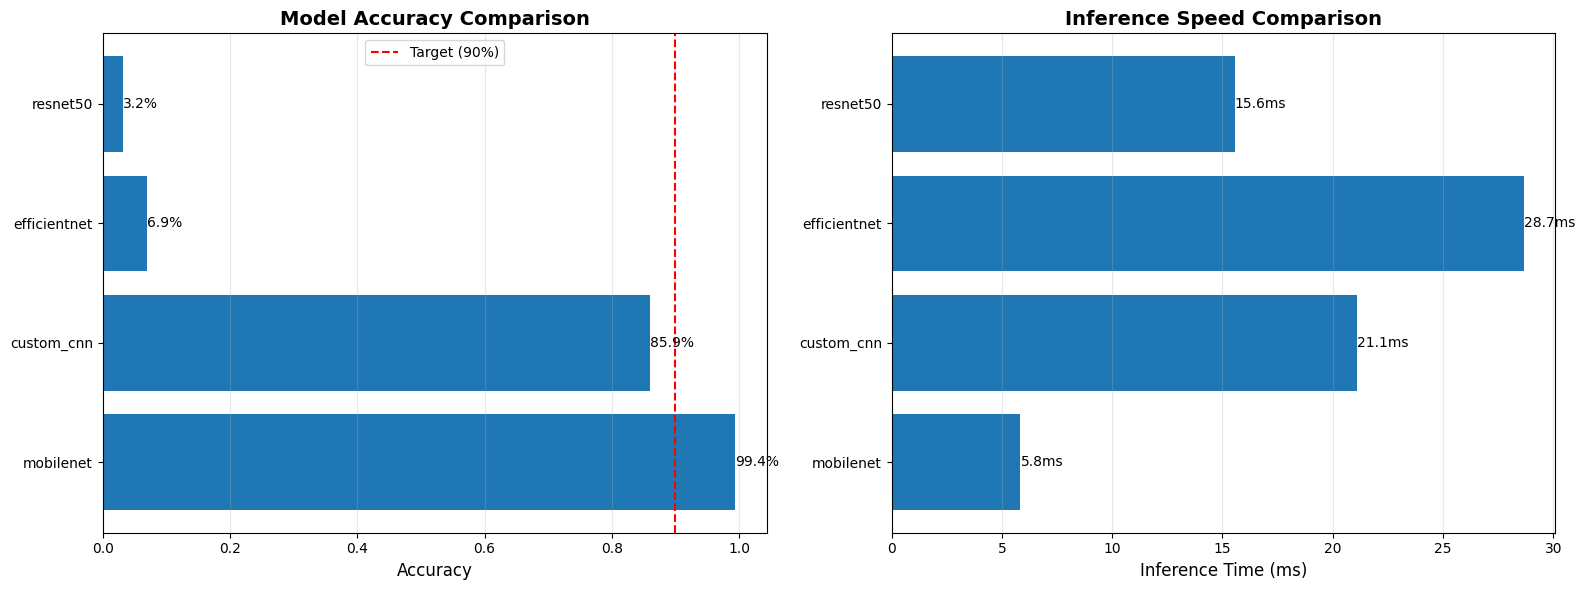


Comparison chart saved


In [28]:
# Create comparison visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
ax1 = axes[0]
bars = ax1.barh(df_comparison['model'], df_comparison['accuracy'])
ax1.set_xlabel('Accuracy', fontsize=12)
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.axvline(x=0.90, color='r', linestyle='--', label='Target (90%)')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2,
             f'{width:.1%}', ha='left', va='center', fontsize=10)

# Speed comparison
ax2 = axes[1]
bars2 = ax2.barh(df_comparison['model'], df_comparison['inference_time_ms'])
ax2.set_xlabel('Inference Time (ms)', fontsize=12)
ax2.set_title('Inference Speed Comparison', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}ms', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.savefig(RESULTS_PATH / 'metrics' / 'model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nComparison chart saved")

## Prediction Examples

In [29]:
def show_prediction_examples(model_name, num_examples=9):
    """Show sample predictions"""
    print(f"\nGenerating prediction examples for {model_name}...")
    
    # Load model
    model = keras.models.load_model(MODELS_PATH / f"{model_name}_best.h5")
    
    # Get test images
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_batch_gen = test_datagen.flow_from_directory(
        DATA_PATH / 'test',
        target_size=(224, 224),
        batch_size=num_examples,
        class_mode='categorical',
        shuffle=True
    )
    
    x_batch, y_batch = next(test_batch_gen)
    predictions = model.predict(x_batch, verbose=0)
    
    # Plot
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    
    for i in range(num_examples):
        ax = axes[i // 3, i % 3]
        ax.imshow(x_batch[i])
        
        true_idx = np.argmax(y_batch[i])
        pred_idx = np.argmax(predictions[i])
        confidence = predictions[i][pred_idx]
        
        true_name = class_names[true_idx]
        pred_name = class_names[pred_idx]
        
        color = 'green' if true_idx == pred_idx else 'red'
        title = f"True: {true_name}\nPred: {pred_name}\nConf: {confidence:.1%}"
        ax.set_title(title, fontsize=9, color=color)
        ax.axis('off')
    
    plt.tight_layout()
    save_path = RESULTS_PATH / 'predictions' / f"{model_name}_examples.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"Saved: {save_path.name}")

# Generate for best model
print("="*80)
print("GENERATING PREDICTION EXAMPLES")
print("="*80)

best_model = df_comparison.iloc[0]['model']
show_prediction_examples(best_model)
print(f"\nShowing examples for best model: {best_model}")

GENERATING PREDICTION EXAMPLES

Generating prediction examples for mobilenet...
Found 626 images belonging to 39 classes.
Saved: mobilenet_examples.png

Showing examples for best model: mobilenet


## Summary Report

In [ ]:
print("="*80)
print("TASK 2.2 COMPLETED: MODEL EVALUATION")
print("="*80)

print("\nGenerated files:")
print(f"  Metrics JSON: {len(all_metrics)} files")
print(f"  Confusion matrices: 4 files")
print(f"  ROC curves: 4 files")
print(f"  Per-class accuracy: 4 files")
print(f"  Comparison table: model_comparison.xlsx")
print(f"  Prediction examples: 1 file")

print("\nAll results saved to:")
print(f"  {RESULTS_PATH}")

print("\n" + "="*80)
print("Next: Task 3.1 - Train YOLOv8 detection models")
print("="*80)

TASK 2.2 COMPLETED: MODEL EVALUATION

Generated files:
  Metrics JSON: 4 files
  Confusion matrices: 4 files
  ROC curves: 4 files
  Per-class accuracy: 4 files
  Comparison table: model_comparison.xlsx
  Prediction examples: 1 file

All results saved to:
  /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/CNN_Attendance_System/results/classification

Next: Task 3.1 - Train YOLOv8 detection models (Kevin)
